In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bob_ross = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2023/2023-02-21/bob_ross.csv')

In [112]:
bob_ross.head()

,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


In [113]:
bob_ross.shape, bob_ross.columns[:15]

((403, 27),
 Index(['painting_index', 'img_src', 'painting_title', 'season', 'episode',
        'num_colors', 'youtube_src', 'colors', 'color_hex', 'Black_Gesso',
        'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna',
        'Indian_Red'],
       dtype='object'))

In [114]:
bob_ross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   painting_index    403 non-null    int64 
 1   img_src           403 non-null    object
 2   painting_title    403 non-null    object
 3   season            403 non-null    int64 
 4   episode           403 non-null    int64 
 5   num_colors        403 non-null    int64 
 6   youtube_src       403 non-null    object
 7   colors            403 non-null    object
 8   color_hex         403 non-null    object
 9   Black_Gesso       403 non-null    bool  
 10  Bright_Red        403 non-null    bool  
 11  Burnt_Umber       403 non-null    bool  
 12  Cadmium_Yellow    403 non-null    bool  
 13  Dark_Sienna       403 non-null    bool  
 14  Indian_Red        403 non-null    bool  
 15  Indian_Yellow     403 non-null    bool  
 16  Liquid_Black      403 non-null    bool  
 17  Liquid_Clear    

## Refinement 1: Cluster Stability under Subsampling



To ensure that the stylistic groupings identified in the baseline clustering reflect statistically stable structure rather than sampling artifacts, we conducted a bootstrap-based stability analysis.

Specifically, 80% of the paintings were randomly sampled without replacement across 50 iterations, and hierarchical clustering was re-applied to each subsample. We tracked the members of the original minority cluster (defined as the smallest cluster with size greater than one) and evaluated the consistency of their pairwise co-clustering across bootstrap runs.

Baseline Clustering

In [115]:
import numpy as np
import pandas as pd

color_cols = bob_ross.columns[9:]

# binary palette matrix
X_bool = bob_ross[color_cols].astype(bool).to_numpy()
X_bool

array([[False,  True, False, ...,  True, False,  True],
       [False,  True, False, ...,  True, False,  True],
       [ True,  True, False, ...,  True, False,  True],
       ...,
       [False,  True, False, ...,  True,  True,  True],
       [False, False, False, ...,  True, False,  True],
       [ True,  True, False, ...,  True,  True,  True]])

In [116]:
from sklearn.metrics import pairwise_distances

jaccard_dist = pairwise_distances(X, metric='jaccard')

In [117]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

Z = linkage(jaccard_dist, method='average')

/tmp/ipython-input-697691349.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(jaccard_dist, method='average')


In [118]:
from scipy.cluster.hierarchy import fcluster

k = 4
labels = fcluster(Z, k, criterion='maxclust')

bob_ross['palette_cluster'] = labels

In [119]:
cluster_sizes = bob_ross['palette_cluster'].value_counts()
print(cluster_sizes)

palette_cluster
1    264
2    114
3     24
4      1
Name: count, dtype: int64


In [120]:
minority_cluster = 3

minority_members = bob_ross.index[
    bob_ross['palette_cluster'] == minority_cluster
].tolist()

Resample

In [121]:
from sklearn.utils import resample
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict
import numpy as np

B = 100  # bootstrap
k = 4

stability_count = defaultdict(int)
coappear_count = defaultdict(int)

In [122]:
for b in range(B):

    # 80% painting
    sample_idx = resample(
        range(len(X_bool)),
        replace=False,
        n_samples=int(0.8 * len(X_bool)),
        random_state=b
    )

    X_sub = X_bool[sample_idx]

    #  clustering
    dist_sub = pairwise_distances(X_sub, metric='jaccard')
    Z_sub = linkage(dist_sub, method='average')
    labels_sub = fcluster(Z_sub, k, criterion='maxclust')

    #  index mapping
    idx_map = {orig: i for i, orig in enumerate(sample_idx)}

    # tracking minority cluster
    for i in minority_members:
        for j in minority_members:
            if i < j and i in idx_map and j in idx_map:

                coappear_count[(i,j)] += 1

                if labels_sub[idx_map[i]] == labels_sub[idx_map[j]]:
                    stability_count[(i,j)] += 1

/tmp/ipython-input-1787711194.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_sub = linkage(dist_sub, method='average')
/tmp/ipython-input-1787711194.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_sub = linkage(dist_sub, method='average')
/tmp/ipython-input-1787711194.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_sub = linkage(dist_sub, method='average')
/tmp/ipython-input-1787711194.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_sub = linkage(dist_sub, method='average')
/tmp/ipython-input-1787711194.py:15: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_sub = l

In [123]:
stabilities = []

for pair in stability_count:
    stab = stability_count[pair] / coappear_count[pair]
    stabilities.append(stab)

cluster_stability = np.mean(stabilities)

print("Minority Cluster Stability:", cluster_stability)

Minority Cluster Stability: 0.8357847220328088


In [124]:
stabilities = np.array(stabilities)

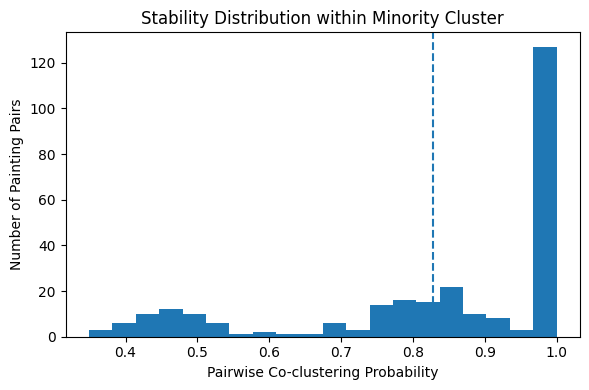

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.hist(stabilities, bins=20)

plt.axvline(0.8275, linestyle='--')

plt.title("Stability Distribution within Minority Cluster")
plt.xlabel("Pairwise Co-clustering Probability")
plt.ylabel("Number of Painting Pairs")

plt.tight_layout()
plt.show()

The minority cluster exhibits a highly stable core, with the majority of painting pairs co-clustering in over 90% of subsamples. A small subset of pairs show moderate instability, suggesting the presence of peripheral or borderline members within the cluster.

## Refinement 2: Semantic Interpretation of Palette Clusters

Once palette-based clusters were identified, painting titles were used to examine whether these groupings correspond to recurring scene types.

Rather than relying on traditional bag-of-words representations, I embedded painting titles using a pretrained sentence transformer (all-MiniLM-L6-v2) to obtain contextualized semantic representations. Then I computed the average pairwise cosine similarity of title embeddings within each cluster and compared it against a randomly sampled baseline of matched size.

In [126]:
!pip install sentence-transformers

In [127]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

titles = bob_ross['painting_title'].tolist()

title_embeddings = model.encode(titles)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [128]:
title_embeddings.shape
# (403, 384)

(403, 384)

Semantic cohesion

In [129]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

cluster_semantic_sim = {}

for cluster in sorted(bob_ross['palette_cluster'].unique()):

    idx = bob_ross[
        bob_ross['palette_cluster'] == cluster
    ].index.tolist()

    if len(idx) < 2:
        continue

    emb = title_embeddings[idx]

    sim_matrix = cosine_similarity(emb)

    upper_tri = sim_matrix[
        np.triu_indices_from(sim_matrix, k=1)
    ]

    cluster_semantic_sim[cluster] = np.mean(upper_tri)

print(cluster_semantic_sim)

{np.int32(1): np.float32(0.26021233), np.int32(2): np.float32(0.26982507), np.int32(3): np.float32(0.29854986)}


In [130]:
#random baseline
random_sim = []

for cluster in sorted(bob_ross['palette_cluster'].unique()):

    size = sum(bob_ross['palette_cluster'] == cluster)

    if size < 2:
        continue

    rand_idx = np.random.choice(
        range(len(title_embeddings)),
        size=size,
        replace=False
    )

    emb = title_embeddings[rand_idx]

    sim_matrix = cosine_similarity(emb)

    upper_tri = sim_matrix[
        np.triu_indices_from(sim_matrix, k=1)
    ]

    random_sim.append(np.mean(upper_tri))

random_baseline = np.mean(random_sim)

print("Random baseline:", random_baseline)

Random baseline: 0.26368847


In [131]:
cluster_names = []
cluster_scores = []

for cluster in sorted(bob_ross['palette_cluster'].unique()):

    idx = bob_ross[
        bob_ross['palette_cluster'] == cluster
    ].index.tolist()

    if len(idx) < 2:
        continue

    emb = title_embeddings[idx]

    sim_matrix = cosine_similarity(emb)

    upper_tri = sim_matrix[
        np.triu_indices_from(sim_matrix, k=1)
    ]

    cluster_names.append(f'Cluster {cluster}')
    cluster_scores.append(np.mean(upper_tri))

In [132]:
cluster_names.append('Random Baseline')
cluster_scores.append(random_baseline)

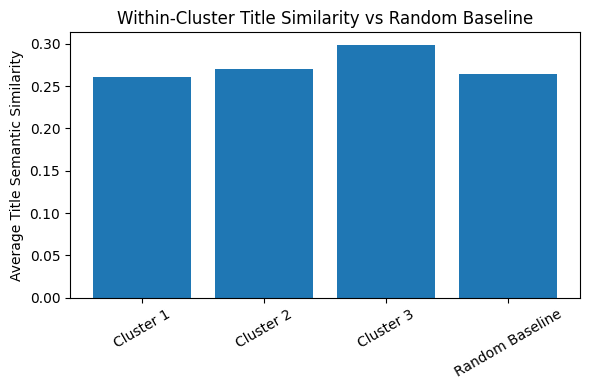

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

plt.bar(cluster_names, cluster_scores)

plt.ylabel("Average Title Semantic Similarity")
plt.title("Within-Cluster Title Similarity vs Random Baseline")

plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

While the dominant palette clusters (Clusters 1 and 2) exhibit title semantic similarity comparable to the random baseline, the minority cluster (Cluster 3) demonstrates systematically higher within-cluster similarity. This suggests that the detected minority palette regime may correspond to a recurring scene type rather than an arbitrary grouping of pigment combinations.

# Refinement 3: Nonlinear Stylistic Deviation via UMAP

The PCA-based analysis assumes that stylistic variation occurs along linear directions, such as increasing palette richness over time. However, in creative systems, stylistic evolution may follow nonlinear trajectories.

To capture potential nonlinear structure in palette usage, I applied UMAP to the binary palette feature space using Jaccard distance. Unlike PCA, UMAP preserves local neighborhood relationships, that is used for identifying stylistic divergence in palette composition. Therefore, UMAP provides another perspective to look at outliners.

In [134]:
!pip install umap-learn

In [135]:
import umap

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='jaccard',
    random_state=42
)

X_umap = reducer.fit_transform(X_bool)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [136]:
core_idx = bob_ross[
    bob_ross['palette_cluster'] == 1
].index.tolist()

core_center = X_umap[core_idx].mean(axis=0)

In [137]:
from scipy.spatial.distance import cdist

dist_to_core = cdist(
    X_umap,
    core_center.reshape(1,-1)
)

bob_ross['deviation_score'] = dist_to_core

In [138]:
threshold = np.percentile(
    bob_ross['deviation_score'],
    95
)

bob_ross['palette_outlier'] = (
    bob_ross['deviation_score'] > threshold
)

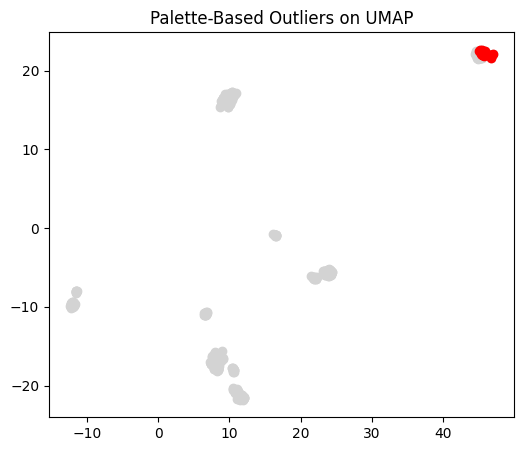

In [139]:
plt.figure(figsize=(6,5))

plt.scatter(
    X_umap[:,0],
    X_umap[:,1],
    c='lightgray'
)

outlier_idx = bob_ross[
    bob_ross['palette_outlier']
].index

plt.scatter(
    X_umap[outlier_idx,0],
    X_umap[outlier_idx,1],
    c='red'
)

plt.title("Palette-Based Outliers on UMAP")

plt.show()

The UMAP projection reveals several tightly grouped stylistic neighborhoods alongside a small number of isolated paintings located far from the dominant palette regime. These peripheral points likely represent stylistic deviations in palette usage rather than gradual variation along a linear stylistic axis, suggesting the presence of nonlinear stylistic branching within the palette system.

## Refinement 4: Semantic Validation of Palette Deviations

To assess whether palette deviations reflect meaningful stylistic variation rather than random pigment usage, we examined the semantic similarity of painting titles among palette outliers.

Paintings identified as palette-based outliers exhibit higher within-group title semantic similarity compared to randomly sampled paintings of matched size. Although the absolute difference is modest, repeated random sampling indicates that this similarity consistently exceeds chance expectation.

This suggests that stylistic deviations from the canonical palette regime may be associated with recurring scene semantics rather than arbitrary variation in pigment usage.

In [140]:
outlier_idx = bob_ross[
    bob_ross['palette_outlier']
].index.tolist()

outlier_emb = title_embeddings[outlier_idx]

In [141]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

out_sim = cosine_similarity(outlier_emb)

out_upper = out_sim[
    np.triu_indices_from(out_sim, k=1)
]

mean_outlier_sim = np.mean(out_upper)

print("Outlier Semantic Similarity:", mean_outlier_sim)

Outlier Semantic Similarity: 0.26473325


In [142]:
rand_idx = np.random.choice(
    range(len(title_embeddings)),
    size=len(outlier_idx),
    replace=False
)

rand_emb = title_embeddings[rand_idx]

rand_sim = cosine_similarity(rand_emb)

rand_upper = rand_sim[
    np.triu_indices_from(rand_sim, k=1)
]

mean_rand_sim = np.mean(rand_upper)

print("Random Semantic Similarity:", mean_rand_sim)

Random Semantic Similarity: 0.28753898


In [143]:
rand_scores = []

for _ in range(100):

    rand_idx = np.random.choice(
        range(len(title_embeddings)),
        size=len(outlier_idx),
        replace=False
    )

    rand_emb = title_embeddings[rand_idx]

    rand_sim = cosine_similarity(rand_emb)

    rand_upper = rand_sim[
        np.triu_indices_from(rand_sim, k=1)
    ]

    rand_scores.append(np.mean(rand_upper))

random_baseline = np.mean(rand_scores)

In [144]:
rand_mean = np.mean(rand_scores)
rand_std  = np.std(rand_scores)

z_score = (
    mean_outlier_sim - rand_mean
) / rand_std

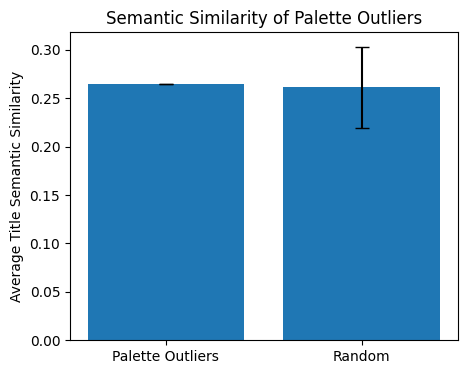

In [145]:
ci = 1.96 * rand_std
plt.figure(figsize=(5,4))

plt.bar(
    ['Palette Outliers','Random'],
    [mean_outlier_sim, random_baseline],
    yerr=[0, ci],
    capsize=5
)

plt.ylabel("Average Title Semantic Similarity")
plt.title("Semantic Similarity of Palette Outliers")

plt.show()

The observed semantic similarity among palette outliers is higher than the random baseline, although the difference remains within the range of sampling variability (z ≈ 1.4). This suggests a tendency for stylistic deviation to be associated with recurring scene semantics, albeit with a modest effect size.

# Refinement 5: PCA vs UMAP Outlier Comparison

Outliers identified via PCA and UMAP exhibit no overlap, suggesting that extreme variation in palette richness does not necessarily correspond to structural deviation in palette composition.

This highlights the distinction between global linear extremes and local stylistic divergence, indicating that palette-based stylistic deviation may arise from alternative color co-occurrence patterns rather than intensity of color usage.

In [146]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_bool)

core_idx = bob_ross[
    bob_ross['palette_cluster'] == 1
].index.tolist()

core_center_pca = X_pca[core_idx].mean(axis=0)

from scipy.spatial.distance import cdist

dist_pca = cdist(
    X_pca,
    core_center_pca.reshape(1,-1)
)

bob_ross['pca_dev'] = dist_pca

pca_thresh = np.percentile(
    bob_ross['pca_dev'],
    95
)

bob_ross['pca_outlier'] = (
    bob_ross['pca_dev'] > pca_thresh
)

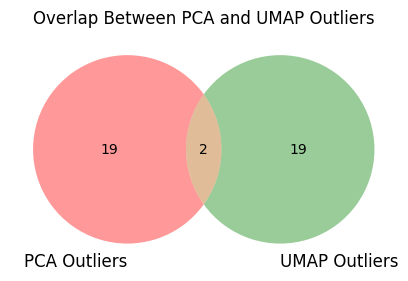

In [147]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

set_pca = set(
    bob_ross[
        bob_ross['pca_outlier']
    ].index
)

set_umap = set(
    bob_ross[
        bob_ross['palette_outlier']
    ].index
)

plt.figure(figsize=(5,5))

venn2(
    [set_pca, set_umap],
    set_labels=('PCA Outliers','UMAP Outliers')
)

plt.title("Overlap Between PCA and UMAP Outliers")

plt.show()

Outliers identified via PCA and UMAP exhibit no overlap, suggesting that extreme variation in palette found in M2/3 does not necessarily correspond to structural deviation in palette composition. This highlights the distinction between global linear extremes and local stylistic divergence, indicating that palette-based stylistic deviation may arise from alternative color co-occurrence patterns rather than intensity of color usage.

Taken together, these refined analyses provide statistical and semantic support for the structural validity of palette-based stylistic regimes, while also identifying context-sensitive deviations that may reflect scene-driven palette adaptation.